Лабораторная работа "Системы ОДУ" (жесткий вариант). Манджиев Улюмджи. Б01-204

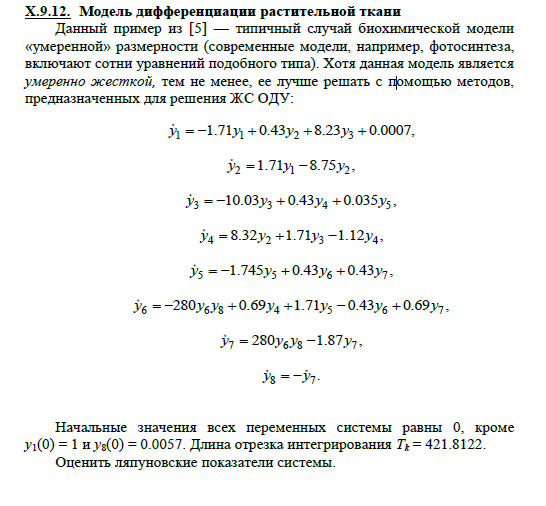

In [3]:
import numpy as np
from scipy.optimize import fsolve
from scipy.linalg import lu_factor, lu_solve
import matplotlib.pyplot as plt

# Определение системы


In [5]:
def plant_tissue(t, y):
    y1, y2, y3, y4, y5, y6, y7, y8 = y
    dy = np.zeros(8)
    
    dy[0] = -1.71*y1 + 0.43*y2 + 8.23*y3 + 0.0007
    dy[1] = 1.71*y1 - 8.75*y2
    dy[2] = -10.03*y3 + 0.43*y4 + 0.035*y5
    dy[3] = 8.32*y2 + 1.71*y3 - 1.12*y4
    dy[4] = -1.745*y5 + 0.43*y6 + 0.43*y7
    dy[5] = -280*y6*y8 + 0.69*y4 + 1.71*y5 - 0.43*y6 + 0.69*y7
    dy[6] = 280*y6*y8 - 1.87*y7
    dy[7] = -dy[6]
    
    return dy

Для дальнейших вычислений необходим якобиан:

In [7]:
def jacobian(t, y):
    y6, y8 = y[5], y[7]
    J = np.zeros((8, 8))
    
    J[0,0], J[0,1], J[0,2] = -1.71, 0.43, 8.23
    J[1,0], J[1,1] = 1.71, -8.75
    J[2,2], J[2,3], J[2,4] = -10.03, 0.43, 0.035
    J[3,1], J[3,2], J[3,3] = 8.32, 1.71, -1.12
    J[4,4], J[4,5], J[4,6] = -1.745, 0.43, 0.43
    J[5,3], J[5,4], J[5,5], J[5,6], J[5,7] = 0.69, 1.71, -0.43-280*y8, 0.69, -280*y6
    J[6,5], J[6,6], J[6,7] = 280*y8, -1.87, 280*y6
    J[7,5], J[7,6], J[7,7] = -280 * y8 , 1.87, -280*y6
    return J

Начальные условия:

In [9]:
y0 = [1.0, 0, 0, 0, 0, 0, 0, 0.0057]
t_span = (0, 421.8122)

# 1. Неявный метод Рунге-Кутта 3-го порядка

In [11]:
def implicit_rk3(func, y0, t_span, h=0.1, tol=1e-8):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    A = np.array([[5/12, -1/12], [3/4, 1/4]])
    b = np.array([3/4, 1/4])
    c = np.array([1/3, 1])
    
    while t[-1] < t_end:
        t_current = t[-1]
        y_current = y[-1].copy()
        
        def equations(k):
            k1, k2 = k[:8], k[8:]
            t1 = t_current + c[0]*h
            y1 = y_current + h*(A[0,0]*k1 + A[0,1]*k2)
            t2 = t_current + c[1]*h
            y2 = y_current + h*(A[1,0]*k1 + A[1,1]*k2)
            return np.concatenate((k1 - func(t1, y1), k2 - func(t2, y2)))
        
        k_initial = np.concatenate([func(t_current, y_current)]*2)
        k_sol = fsolve(equations, k_initial, xtol=tol, maxfev=100)  
        k1, k2 = k_sol[:8], k_sol[8:]
        
        y_next = y_current + h*(b[0]*k1 + b[1]*k2)
        y.append(y_next)
        t.append(t_current + h)
    
    return np.array(t), np.array(y)

# 2. Неявные методы ФДН 4-6 порядка

In [13]:
def fdn4_method(func, y0, t_span, h=0.1, tol=1e-8):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    
    # Разгонный участок методом РК4 
    for _ in range(3): # нужно 4 точки
        k1 = func(t[-1], y[-1])
        k2 = func(t[-1] + h/2, y[-1] + h/2 * k1)
        k3 = func(t[-1] + h/2, y[-1] + h/2 * k2)
        k4 = func(t[-1] + h, y[-1] + h * k3)
        y_next = y[-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        y.append(y_next)
        t.append(t[-1] + h)
    
    # Основной цикл
    while t[-1] < t_end:
        coeff = [
            4.0,          # коэффициент при y_n
            -3.0,          # коэффициент при y_{n-1}
            4.0/3.0,       # коэффициент при y_{n-2}
            -1.0/4.0       # коэффициент при y_{n-3}
        ]
        
        #правая часть уравнения
        rhs = (
            coeff[0] * y[-1] + 
            coeff[1] * y[-2] + 
            coeff[2] * y[-3] + 
            coeff[3] * y[-4]
        )
        
        def equation(y_next):
            return (25/12) * y_next - h * func(t[-1] + h, y_next) - rhs
        
        # Решение нелинейного уравнения
        y_next_guess = y[-1]
        y_next_sol = fsolve(equation, y_next_guess, xtol=tol, maxfev=300)
        
        y.append(y_next_sol)
        t.append(t[-1] + h)
    
    return np.array(t), np.array(y)

def fdn5_method(func, y0, t_span, h=0.1, tol=1e-8):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    
    for _ in range(4): # нужно 5 точки
        k1 = func(t[-1], y[-1])
        k2 = func(t[-1] + h/2, y[-1] + h/2 * k1)
        k3 = func(t[-1] + h/2, y[-1] + h/2 * k2)
        k4 = func(t[-1] + h, y[-1] + h * k3)
        y_next = y[-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        y.append(y_next)
        t.append(t[-1] + h)
    
    while t[-1] < t_end:
        
        coeff = [
            5.0,           # y_n
            -5.0,          # y_{n-1}
            10.0/3.0,      # y_{n-2}
            -5.0/4.0,      # y_{n-3}
            1.0/5.0        # y_{n-4}
        ]

        rhs = (
            coeff[0] * y[-1] +
            coeff[1] * y[-2] +
            coeff[2] * y[-3] +
            coeff[3] * y[-4] +
            coeff[4] * y[-5]
        )
        
        def equation(y_next):
            return (137/60) * y_next - h * func(t[-1] + h, y_next) - rhs

        y_next_guess = y[-1]
        y_next_sol = fsolve(equation, y_next_guess, xtol=tol, maxfev=300)
        
        y.append(y_next_sol)
        t.append(t[-1] + h)
    
    return np.array(t), np.array(y)


def fdn6_method(func, y0, t_span, h=0.1, tol=1e-8):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    

    for _ in range(5): # нужно 6 точки
        k1 = func(t[-1], y[-1])
        k2 = func(t[-1] + h/2, y[-1] + h/2 * k1)
        k3 = func(t[-1] + h/2, y[-1] + h/2 * k2)
        k4 = func(t[-1] + h, y[-1] + h * k3)
        y_next = y[-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
        y.append(y_next)
        t.append(t[-1] + h)
    
    while t[-1] < t_end:
        
        coeff = [
            6.0,           # y_n
            -15.0/2.0,     # y_{n-1}
            20.0/3.0,      # y_{n-2}
            -15.0/4.0,    # y_{n-3}
            6.0/5.0,       # y_{n-4}
            -1.0/6.0       # y_{n-5}
        ]
        
        rhs = (
            coeff[0] * y[-1] +
            coeff[1] * y[-2] +
            coeff[2] * y[-3] +
            coeff[3] * y[-4] +
            coeff[4] * y[-5] +
            coeff[5] * y[-6]
        )
        
        def equation(y_next):
            return (147/60) * y_next - h * func(t[-1] + h, y_next) - rhs
        
        y_next_guess = y[-1]
        y_next_sol = fsolve(equation, y_next_guess, xtol=tol, maxfev=300)
        
        y.append(y_next_sol)
        t.append(t[-1] + h)
    
    return np.array(t), np.array(y)

# 3. Метод Розенброка с обработкой сингулярных матриц

In [15]:
def rosenbrock_method(func, jac, y0, t_span, h=0.1, gamma=1):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    
    while t[-1] < t_end:
        try:
            J = jac(t[-1], y[-1])
            I = np.eye(8)
            F = func(t[-1], y[-1])
            
            L = I - gamma*h*J
            lu, piv = lu_factor(L)
            k1 = lu_solve((lu, piv), h*F)
            
            F2 = func(t[-1], y[-1] + k1)
            rhs = h*F2 - 2*k1
            k2 = lu_solve((lu, piv), rhs)
            
            y_next = y[-1] + 1.5*k1 + 0.5*k2
            y.append(y_next)
            t.append(t[-1] + h)
        except:
            print(f"Ошибка на шаге t={t[-1]}. Прерывание.")
            break
    
    return np.array(t), np.array(y)

# 4. Явный метод Рунге-Кутты 4-го порядка

In [17]:
def explicit_rk4(func, y0, t_span, h=0.1):
    t_start, t_end = t_span
    t = [t_start]
    y = [np.array(y0)]
    
    while t[-1] < t_end:
        k1 = func(t[-1], y[-1])
        k2 = func(t[-1] + h/2, y[-1] + h/2*k1)
        k3 = func(t[-1] + h/2, y[-1] + h/2*k2)
        k4 = func(t[-1] + h, y[-1] + h*k3)
        
        y_next = y[-1] + h/6*(k1 + 2*k2 + 2*k3 + k4)
        y.append(y_next)
        t.append(t[-1] + h)
    
    return np.array(t), np.array(y)

# Решение

In [19]:
t_rk, y_rk = implicit_rk3(plant_tissue, y0, t_span, h=0.01)
t_fdn4, y_fdn4 = fdn4_method(plant_tissue, y0, t_span, h=0.01)
t_fdn5, y_fdn5 = fdn5_method(plant_tissue, y0, t_span, h=0.01)
t_fdn6, y_fdn6 = fdn6_method(plant_tissue, y0, t_span, h=0.01)
t_ros, y_ros = rosenbrock_method(plant_tissue, jacobian, y0, t_span, h=0.001)
t_explicit, y_explicit = explicit_rk4(plant_tissue, y0, t_span, h=0.01)

C:\Users\ylumd\AppData\Local\Temp\ipykernel_29488\3751529132.py:22: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  k_sol = fsolve(equations, k_initial, xtol=tol, maxfev=100)
C:\Users\ylumd\AppData\Local\Temp\ipykernel_29488\3751529132.py:22: RuntimeWarning: The number of calls to function has reached maxfev = 100.
  k_sol = fsolve(equations, k_initial, xtol=tol, maxfev=100)


# Визуализация для всех методов

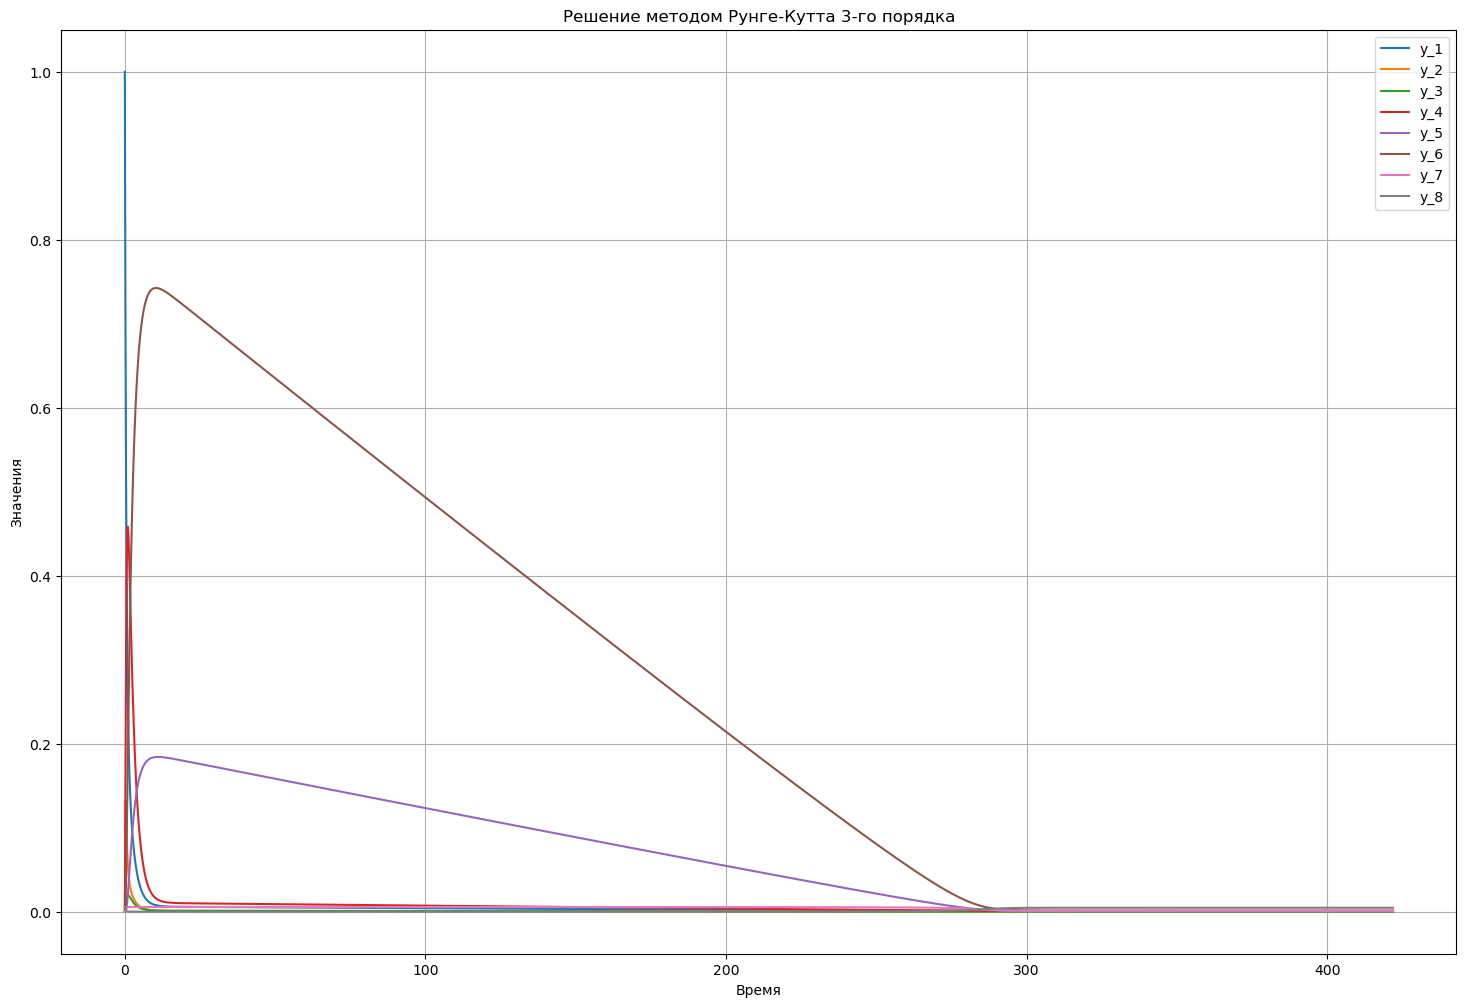

In [21]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_rk, y_rk[:, i], label=f'y_{i+1}')
plt.title('Решение методом Рунге-Кутта 3-го порядка')
plt.xlabel('Время')
plt.ylabel('Значения')
plt.legend()
plt.grid()
plt.show()

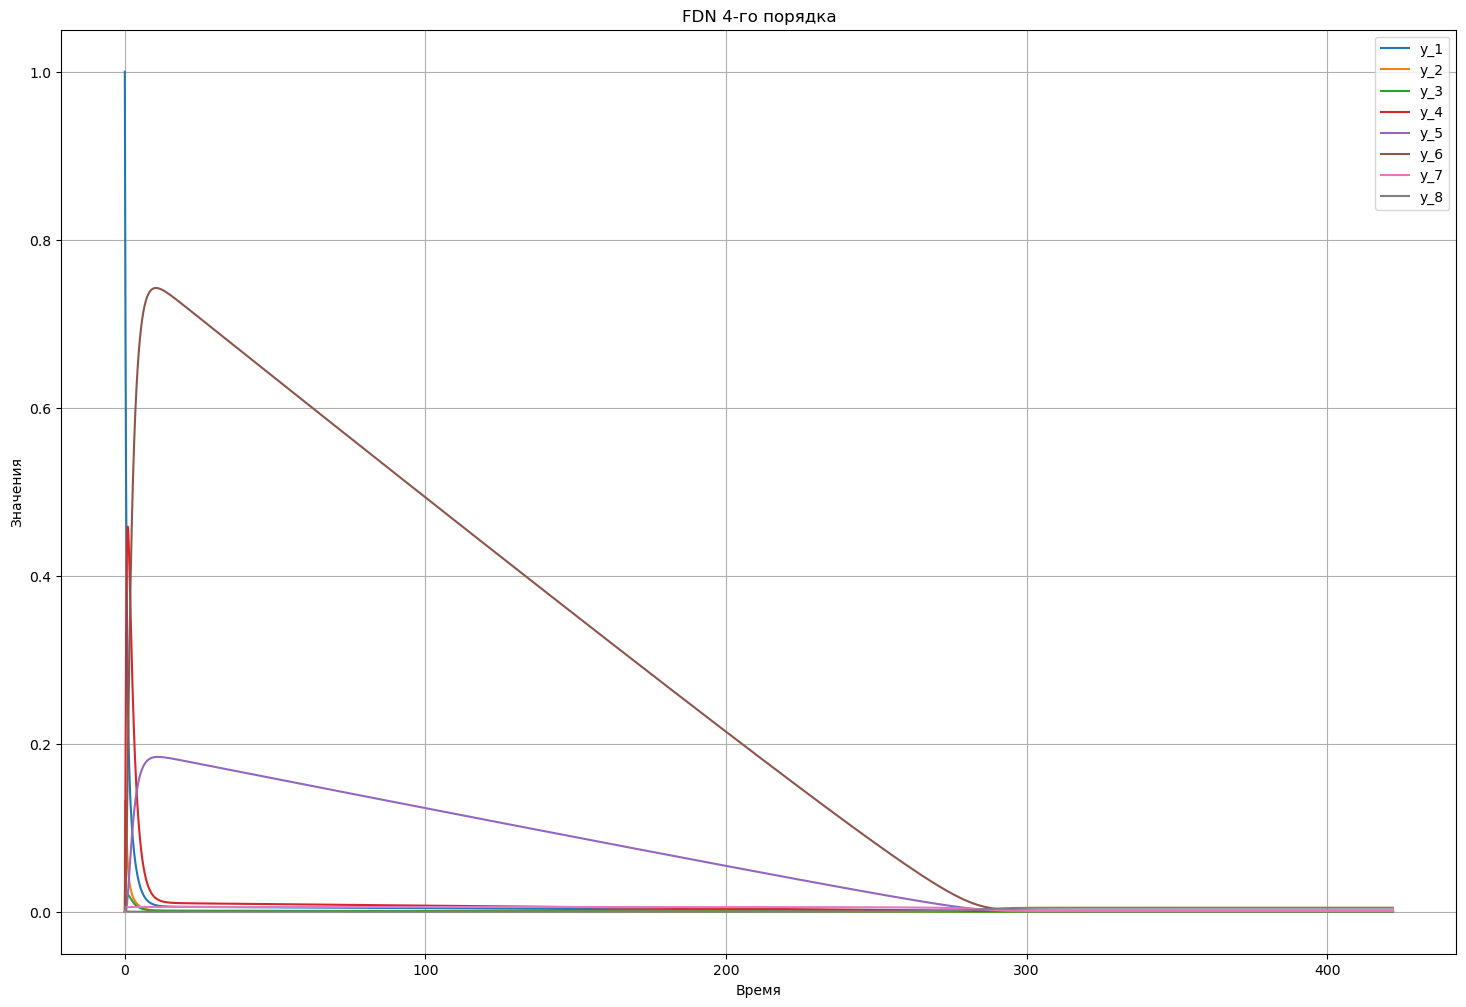

In [22]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_fdn4, y_fdn4[:, i], label=f'y_{i+1}')
plt.title('FDN 4-го порядка')
plt.xlabel('Время') 
plt.ylabel('Значения')  
plt.legend()  
plt.grid()
plt.show()

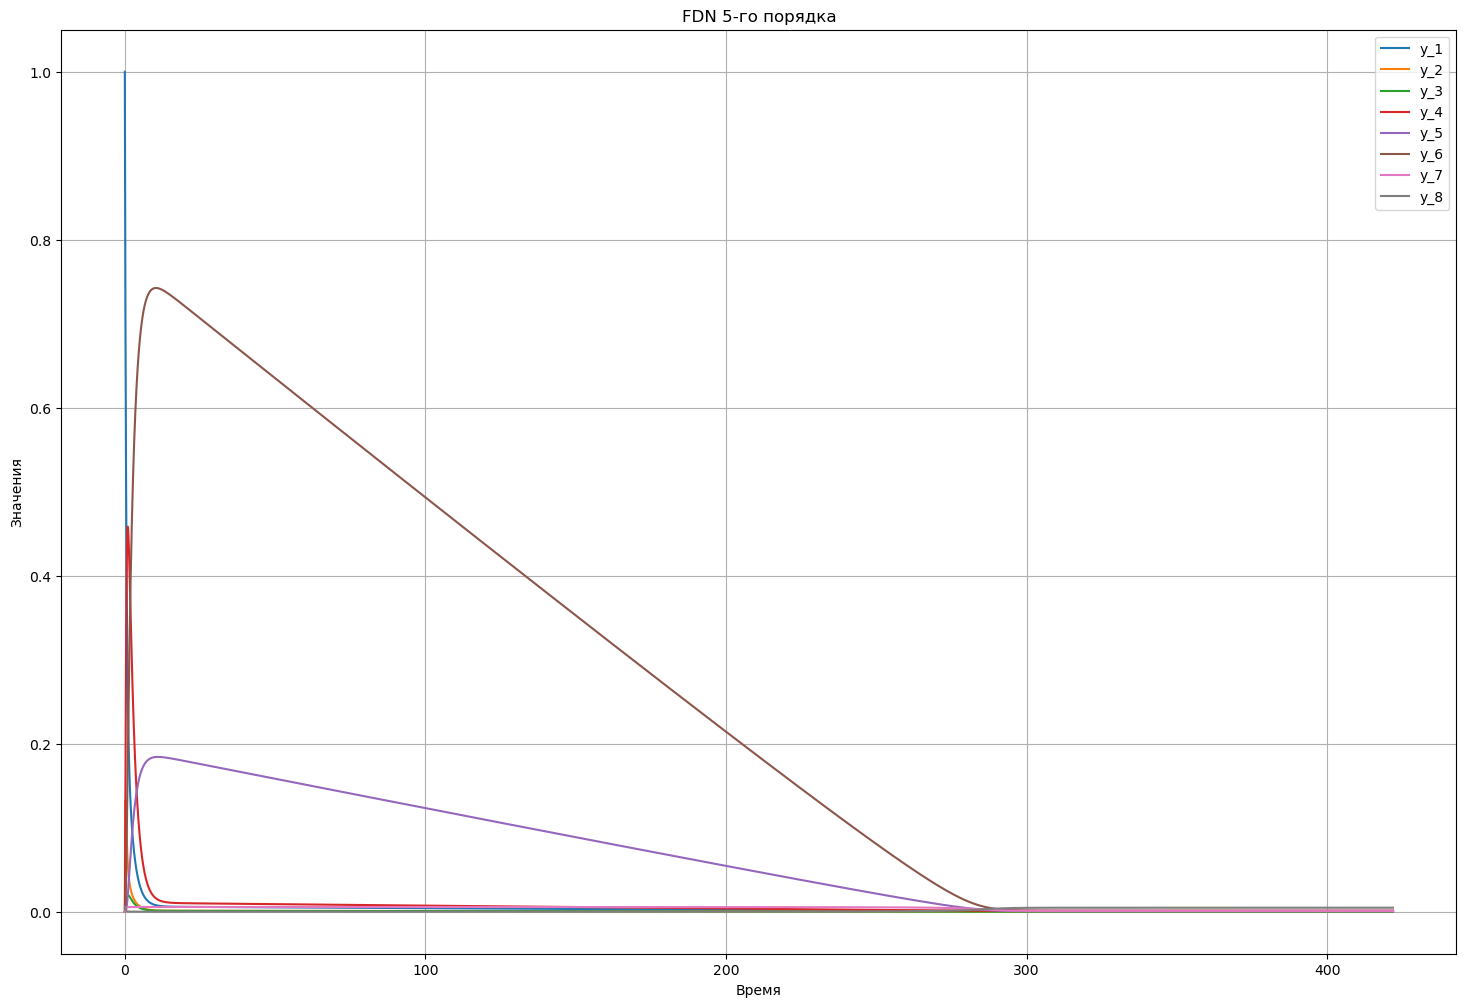

In [23]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_fdn5, y_fdn5[:, i], label=f'y_{i+1}')
plt.title('FDN 5-го порядка')
plt.xlabel('Время') 
plt.ylabel('Значения')  
plt.legend()  
plt.grid()
plt.show()

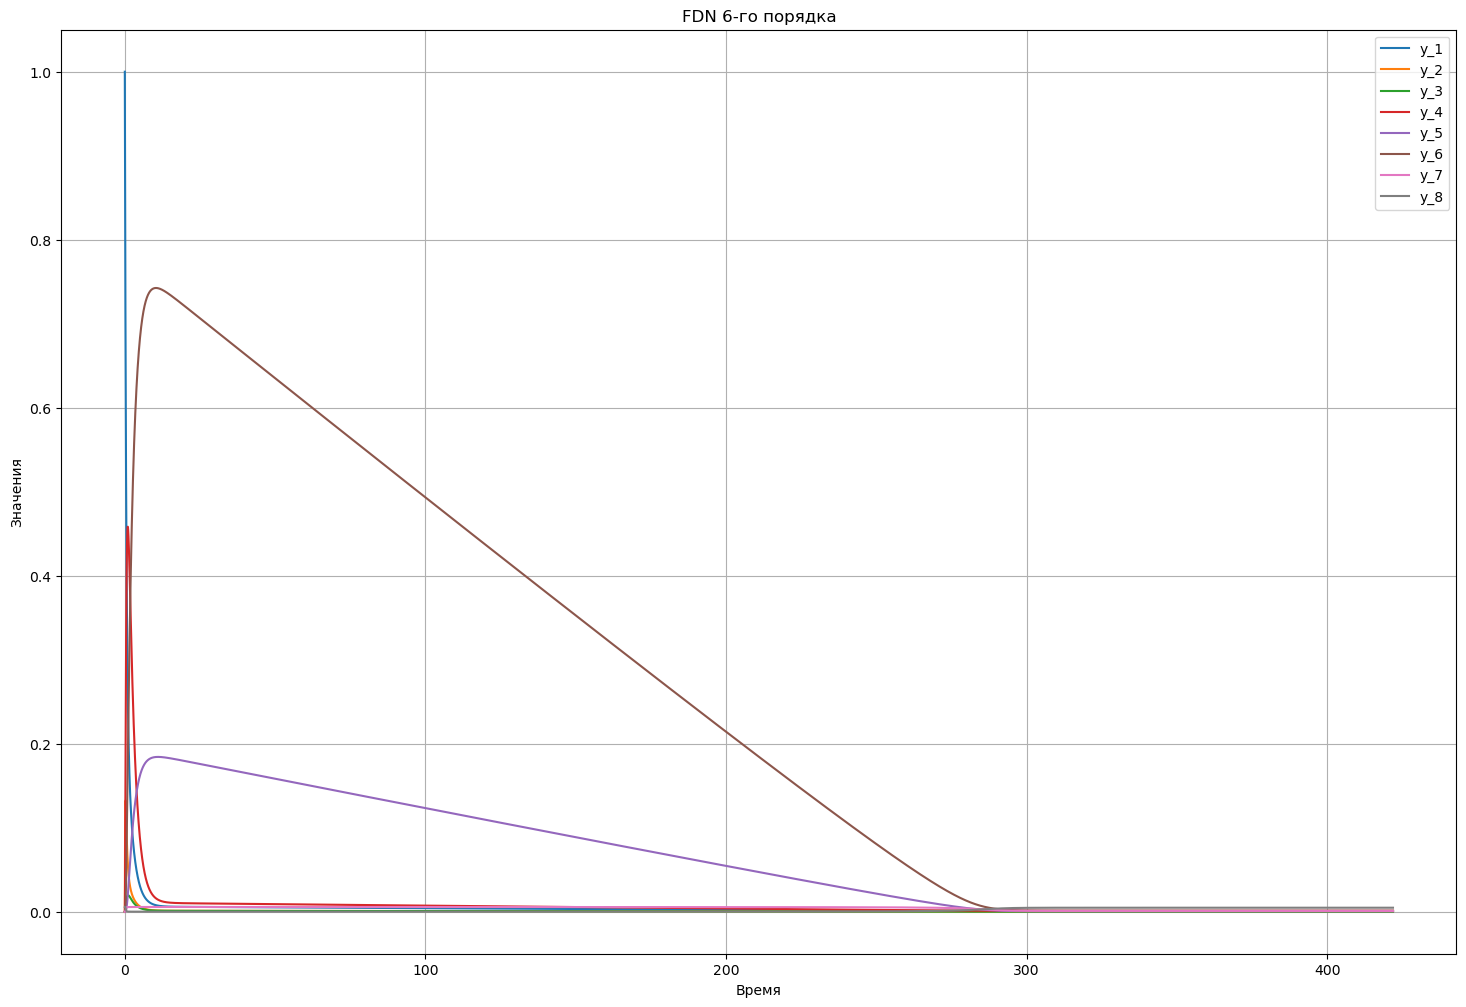

In [24]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_fdn6, y_fdn6[:, i], label=f'y_{i+1}')
plt.title('FDN 6-го порядка')
plt.xlabel('Время') 
plt.ylabel('Значения')  
plt.legend()  
plt.grid()
plt.show()

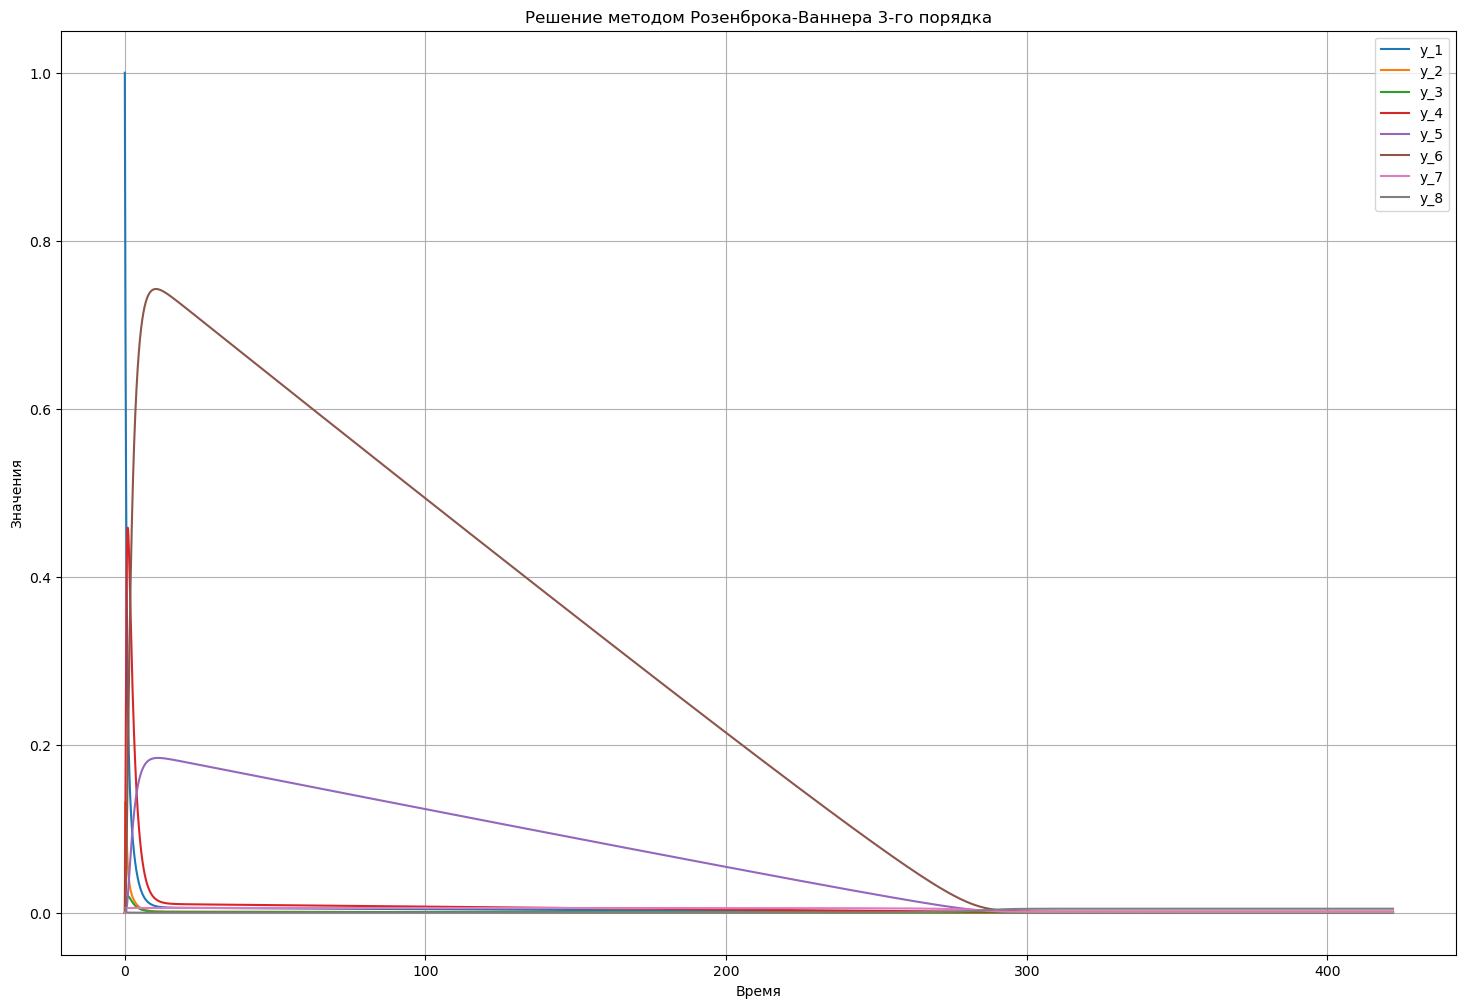

In [25]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_ros, y_ros[:, i], label=f'y_{i+1}')
plt.title('Решение методом Розенброка-Ваннера 3-го порядка')    
plt.xlabel('Время') 
plt.ylabel('Значения')  
plt.legend()    
plt.grid()
plt.show()

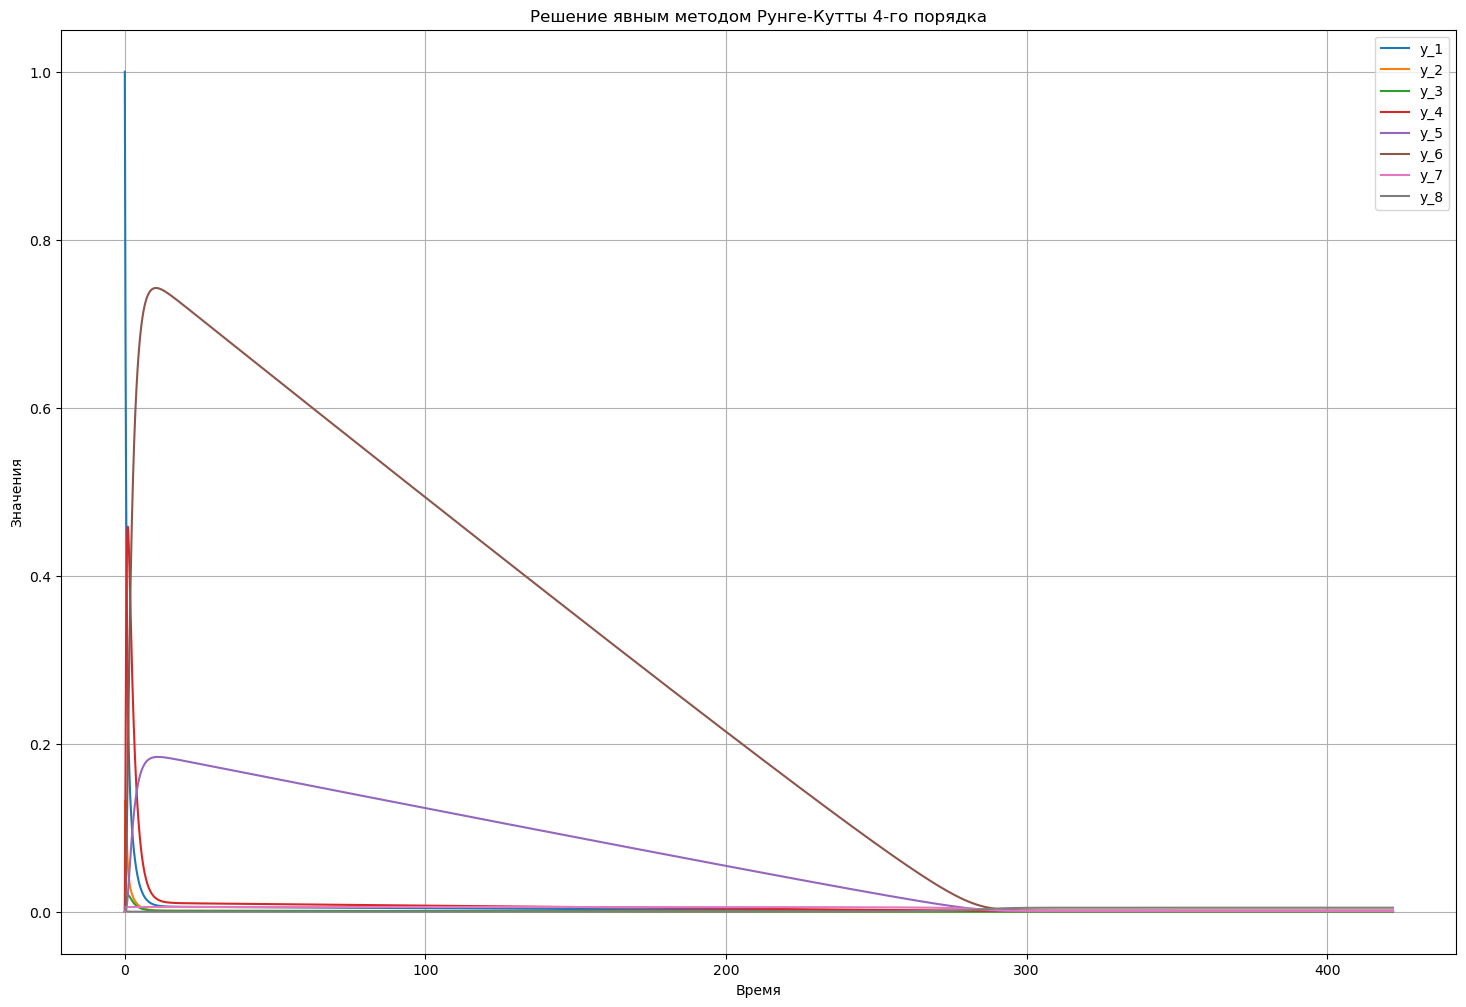

In [26]:
plt.figure(figsize=(18, 12))
for i in range(8):
    plt.plot(t_explicit, y_explicit[:, i], label=f'y_{i+1}')
plt.title('Решение явным методом Рунге-Кутты 4-го порядка')    
plt.xlabel('Время') 
plt.ylabel('Значения')  
plt.legend()    
plt.grid()

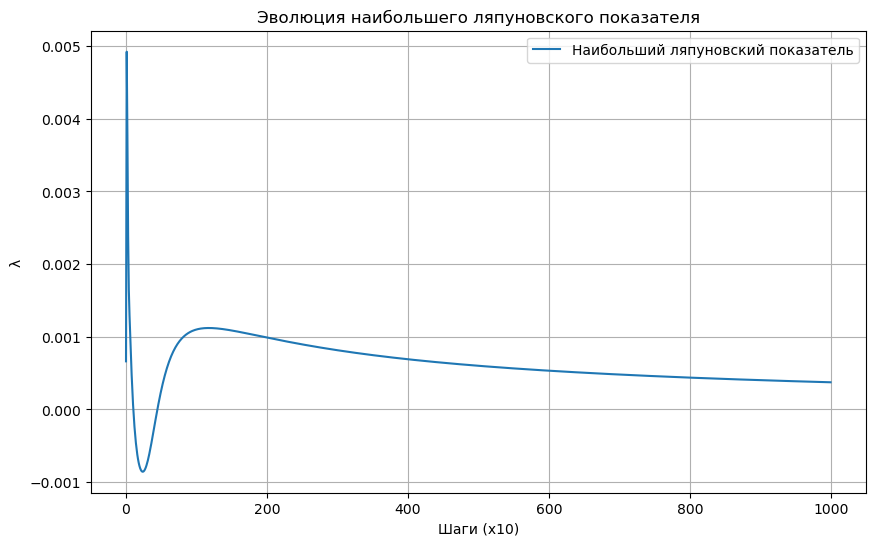

In [27]:
def compute_lyapunov_exponent(func, jacobian, y0, t_span, h=0.01, max_steps=10000, ortho_step=10):
    # Интегрирование основной траектории
    t = [t_span[0]]
    y = [np.array(y0, dtype=np.float64)]
    n = len(y0)
    
    # Начальное возмущение
    perturbation = np.ones(n)
    perturbation /= np.linalg.norm(perturbation)
    
    lyap_sum = 0.0
    lyap_exp = []
    
    # Интегрирование основной системы и вариаций
    for step in range(max_steps):
        # Интегрирование основной системы (метод Розенброка для устойчивости)
        J = jacobian(t[-1], y[-1])
        L = np.eye(n) - h * J
        F = func(t[-1], y[-1])
        y_next = y[-1] + h * np.linalg.solve(L, F)
        y.append(y_next)
        t.append(t[-1] + h)
        
        # Интегрирование вариационного уравнения
        perturbation = np.linalg.solve(L, perturbation)
        
        # Ортогонализация и накопление
        if step % ortho_step == 0:
            norm = np.linalg.norm(perturbation)
            lyap_sum += np.log(norm)
            perturbation /= norm
            
            # Текущий показатель
            current_lyap = lyap_sum / (step + 1)
            lyap_exp.append(current_lyap)
    
    return np.array(lyap_exp)

lyap_exp = compute_lyapunov_exponent(
    plant_tissue, 
    jacobian, 
    y0, 
    t_span, 
    h=0.01, 
    max_steps=10000
)

plt.figure(figsize=(10, 6))
plt.plot(lyap_exp, label='Наибольший ляпуновский показатель')
plt.xlabel('Шаги (x10)')
plt.ylabel('λ')
plt.title('Эволюция наибольшего ляпуновского показателя')
plt.grid()
plt.legend()
plt.show()